In [1]:
import sys
sys.path.append("../../marineHeatWaves/")
sys.path.append("physiology/")

import marineHeatWaves as mh

from tpc import tpc

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import tqdm

import seaborn as sns

from functools import partial

from dask.distributed import Client

import gcsfs
import s3fs 
import boto3

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [2]:
client = Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:36813 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 32 Memory: 132.82 GB


# Phytoplankton Isolates + MHWs. 

Tony Cannistra, Apr 2020

Taking a step back from latitudinally extrapolating thermal reaction norms, we instead move to looking at SST dynamics local to individual phytoplankton isolates to remove some potentially negative effects of the extrapolation . 

In [4]:
plankton = pd.read_csv("../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')
plankton = plankton[
    (plankton.habitat == 'marine') &
    (plankton.curvequal == 'good')
].dropna(subset=['isolation.latitude', 'isolation.longitude'], axis=0)
len(plankton)

89

## Set up MHW detection

In [5]:

SAVED_PARAMS = [
    'intensity_max',
    'intensity_cumulative',
    'intensity_var',
    'intensity_mean',
    'rate_onset',
    'rate_decline',
    'index_start', 
    'index_end',
    'index_peak',
    'duration'
]
dim_idx_mapping = {
        **{
            i : SAVED_PARAMS[i]
            for i in range(len(SAVED_PARAMS))
        }, 
        **{
            len(SAVED_PARAMS): 'mhw',
            len(SAVED_PARAMS) + 1 : 'clim_thresh',
            len(SAVED_PARAMS) + 2 : 'clim_seas'
        }
}
def mhw_1d(temps, time):
    SAVED_PARAMS_loc = SAVED_PARAMS.copy()
    if(np.isnan(temps).any()): return np.zeros((len(SAVED_PARAMS_loc) + 3, time.shape[0]))

    ordinals =  np.array([pd.Timestamp(t).toordinal() for t in time])
    dets = mh.detect(ordinals, temps.copy())
    events = dets[0]['n_events']
    del dets[0]['n_events']
    
    arrays = [
        np.zeros_like(time, dtype='float64')
        for _ in range(len(SAVED_PARAMS_loc)) 
    ]
    arrays.append(np.zeros_like(time, dtype='int'))
    
    for event_i in range(events):
        start_date = dets[0]['index_start'][event_i]
        end_date = dets[0]['index_end'][event_i]
        
        # set binary param
        arrays[-1][start_date:end_date] = event_i
        # set all params
        for _i, param in enumerate(SAVED_PARAMS_loc):
#             print(f'saving param {param}')
            param_data = dets[0][param][event_i]
            arrays[_i][start_date:end_date] = param_data
                
        
    clim_thresh = dets[1]['thresh'] 
    clim_seas = dets[1]['seas']
        
    return np.array(
        arrays + [clim_thresh, clim_seas]
    )

def get_nearest_mhw_detections(sst, lat, lon):
    these_sst = sst.sel(lat=lat, lon=lon, method='nearest', tolerance=0.25)
    dets = xr.apply_ufunc(
        mhw_1d, 
        these_sst.sst.chunk({'time': -1}), 
        these_sst.time, 
        input_core_dims = [['time'], ['time']],
        output_core_dims=[["param","time"]],
        output_dtypes=['float64'],
        dask='parallelized', 
        output_sizes={"param": len(SAVED_PARAMS) + 3}, # + 3 for binary MHW detection parameter and climatology
        vectorize=True
    )
    return(dets.to_dataset(dim='param').rename_vars(dim_idx_mapping))

Load MHWs

In [6]:
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

Test on one example:

In [38]:
example_plank = plankton.sample(1)

In [66]:
dets = get_nearest_mhw_detections(oisst, example_plank['isolation.latitude'], example_plank['isolation.longitude'])

In [67]:
dets = dets.compute().to_dataset(dim='param').rename_vars(dim_idx_mapping)

Run all examples:

In [7]:
loc_dets = [get_nearest_mhw_detections(oisst, x['isolation.latitude'], x['isolation.longitude'])
               for _, x in plankton.iterrows()
           ]

In [8]:
loc_dets_values = client.compute(loc_dets, sync=True, optimize_graph=True)

## Compute TPCs for each isolate

In [10]:
tpcs = [
    partial(tpc,
            a=s['mu.alist'], b=s['mu.blist'], z=s['mu.c.opt.list'], w=s['mu.wlist'])
    for _, s in plankton.iterrows()
]

## Compute performance for each isolate

In [11]:
tmax_col = 'tmax'
tmin_col = 'tmin'
topt_col = 'mu.g.opt.list'

In [13]:
performances = []
for i, (_, isolate) in tqdm.tqdm(enumerate(plankton.iterrows())):
    
    _tpc = tpcs[i]
    _relevant_sst = oisst.sel(
        lat=isolate['isolation.latitude'], 
        lon=isolate['isolation.longitude'],
        method='nearest', tolerance=0.25
    )
    _tmin = isolate[tmin_col]
    _tmax = isolate[tmax_col]
    _topt = isolate[topt_col]
    values = xr.apply_ufunc(
        _tpc,
        _relevant_sst.chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).sst.T
    
    _relevant_mhws = loc_dets_values[i]
    
        
    performance = xr.full_like(_relevant_sst, fill_value=0.).rename_vars({'sst' : "performance"})
    performance['performance_clim'] = xr.zeros_like(performance.performance)
    performance['topt'] = xr.zeros_like(performance.performance)
    performance['tmin'] = xr.zeros_like(performance.performance)
    performance['tmax'] = xr.zeros_like(performance.performance)
    performance.attrs = {}
    
    values_clim = xr.apply_ufunc(
        _tpc,
        _relevant_mhws.clim_seas.chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).T
    
    performance['performance'] = values
    
    performance['performance_clim'] = values_clim
    
    performance['topt'] = _topt
    
    performance['tmin'] = _tmin
    
    performance['tmax'] = _tmax
    
    performances.append(performance)
    


0it [00:00, ?it/s]
6it [00:00, 52.51it/s]
12it [00:00, 52.80it/s]
18it [00:00, 52.76it/s]
24it [00:00, 53.01it/s]
30it [00:00, 52.76it/s]
35it [00:00, 51.70it/s]
41it [00:00, 52.14it/s]
47it [00:00, 52.34it/s]
53it [00:01, 52.59it/s]
59it [00:01, 52.77it/s]
65it [00:01, 52.36it/s]
71it [00:01, 52.76it/s]
77it [00:01, 52.66it/s]
83it [00:01, 52.26it/s]
89it [00:01, 52.40it/s]


In [14]:
performance = client.compute(performances, sync=True, optimize_graph=True)

## Merge MHWs and Performance for analysis 

In [18]:
isolate_merged_performance = [xr.merge(merge) for merge in zip(loc_dets_values, performance)]

In [21]:
isolate_combined = xr.concat(isolate_merged_performance, dim='isolate')

In [28]:
mhws = isolate_combined.where((isolate_combined.mhw != 0) & (isolate_combined.duration > 25))

In [43]:
mhws_ddf = mhws.isel(isolate=slice(20, 30)).to_dask_dataframe().dropna()

In [44]:
mhws_ddf.head()

,isolate,time,lat,lon,intensity_max,intensity_cumulative,intensity_var,intensity_mean,rate_onset,rate_decline,...,index_peak,duration,mhw,clim_thresh,clim_seas,performance,performance_clim,topt,tmin,tmax
8555,0,2005-02-02,8.625,-52.375,1.523165,30.884922,0.227551,1.103033,0.057877,0.053874,...,8568.0,28.0,24.0,27.355612,26.772059,0.391900,0.404117,26.550246,14.490219,32.023812
8556,0,2005-02-03,8.625,-52.375,1.523165,30.884922,0.227551,1.103033,0.057877,0.053874,...,8568.0,28.0,24.0,27.356128,26.769797,0.393841,0.404125,26.550246,14.490219,32.023812
8557,0,2005-02-04,8.625,-52.375,1.523165,30.884922,0.227551,1.103033,0.057877,0.053874,...,8568.0,28.0,24.0,27.356773,26.767645,0.394046,0.404133,26.550246,14.490219,32.023812
8558,0,2005-02-05,8.625,-52.375,1.523165,30.884922,0.227551,1.103033,0.057877,0.053874,...,8568.0,28.0,24.0,27.357225,26.765659,0.384399,0.404140,26.550246,14.490219,32.023812
8559,0,2005-02-06,8.625,-52.375,1.523165,30.884922,0.227551,1.103033,0.057877,0.053874,...,8568.0,28.0,24.0,27.357548,26.763832,0.376328,0.404147,26.550246,14.490219,32.023812


In [92]:
def compute_mhw_performance(df):
    return pd.Series({
        'isolate' : df.isolate.min(),
        'detriment_sum' : (1 - df.performance).sum(),
        'detriment_mean' : (1 - df.performance).mean(),
        'performance_diff_sum' : (df.performance - df.performance_clim).sum(),
        'performance_ratio_mean' : (df.performance / df.performance_clim).mean(),
        'intensity_cumulative' : df.intensity_cumulative.min(),
        'intensity_mean': df.intensity_mean.min(),
        'duration' : df.duration.min(),
        'start_doy' : df.time.dt.dayofyear.min(),
        'perf_det_ratio' : ((1-df.performance) / (1-df.performance_clim)).mean()
    })


In [93]:
%%time
a = mhws_ddf.groupby(['lat', 'lon', 'mhw']).apply(compute_mhw_performance).compute()

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


CPU times: user 201 ms, sys: 17.5 ms, total: 218 ms
Wall time: 438 ms


In [94]:
a

isolate  detriment_sum  detriment_mean  \
lat    lon      mhw                                            
8.625  -52.375  24.0      0.0      16.524133        0.612005   
                35.0      0.0      22.257968        0.741932   
                81.0      0.0      18.840721        0.724643   
9.875  -89.125  2.0       1.0      19.386833        0.312691   
                3.0       1.0      11.515966        0.460639   
                6.0       1.0      18.250003        0.405556   
                26.0      1.0      14.334549        0.281070   
                27.0      1.0      13.120833        0.336432   
                43.0      1.0       7.836419        0.279872   
                59.0      1.0      12.013820        0.400461   
                60.0      1.0      11.579243        0.373524   
                61.0      1.0      15.194251        0.330310   
12.375 -56.125  16.0      2.0      -8.535485       -0.133367   
                17.0      2.0      -7.904977       -0.292777   
                28.0      2.0      -3.050357       -0.080273   
                29.0      2.0     -13.752438       -0.292605   
                30.0      2.0     -10.072969       -0.305241   
                34.0      2.0      -5.393195       -0.163430   
                41.0      2.0      -6.398522       -0.255941   
14.625 -96.875  64.0      3.0       4.992078        0.199683   
22.875 -158.125 18.0      5.0      53.971715        0.817753   
                46.0      5.0      36.359234        0.363592   
                49.0      5.0      65.534285        0.409589   
                50.0      5.0     189.209418        0.946047   
                57.0      5.0      97.944229        0.830036   
                59.0      5.0      98.497476        0.456007   
       -157.875 16.0      4.0      21.881821        0.663085   
                43.0      4.0      45.783874        0.654055   
                48.0      4.0      51.463668        0.659791   
                49.0      4.0      80.894457        0.709601   
                57.0      4.0      33.528654        0.670573   
                59.0      4.0      63.432213        0.647267   
24.375  118.125 28.0      7.0      33.438937        0.668779   
                45.0      7.0      41.908726        0.634981   
                47.0      7.0      37.404771        0.584450   
                53.0      7.0      31.508369        0.543248   
                70.0      7.0      30.205418        0.487184   

                      performance_diff_sum  performance_ratio_mean  \
lat    lon      mhw                                                  
8.625  -52.375  24.0             -0.436607                0.959990   
                35.0             -2.931954                0.724858   
                81.0             -1.976082                0.783608   
9.875  -89.125  2.0              -4.965841                0.895771   
                3.0              -4.995743                0.729604   
                6.0              -5.670366                0.824746   
                26.0             -2.671241                0.932163   
                27.0             -3.995677                0.866257   
                43.0             -1.252735                0.941488   
                59.0             -4.268371                0.808182   
                60.0             -4.124945                0.824784   
                61.0             -4.709782                0.867437   
12.375 -56.125  16.0             25.140390                1.532788   
                17.0              7.242942                1.263198   
                28.0             13.502679                1.489792   
                29.0             12.741907                1.267822   
                30.0              7.715591                1.218355   
                34.0              8.460958                1.284868   
                41.0              4.830047                1.183129   
14.625 -96.875  64.0             -5.770350             

In [95]:
a = a.reset_index()

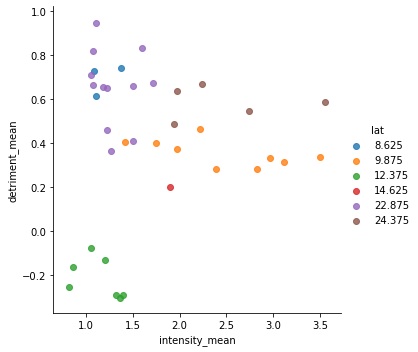

In [98]:
sns.lmplot(x = 'intensity_mean', y = 'detriment_mean', hue='lat',  data = a, fit_reg=False )